In [45]:
import paddle
from utils import load_image_to_array
import numpy as np
import os
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
import matplotlib.pyplot as plt
from paddle.io import Dataset
from paddle.vision.transforms import Compose, Normalize

In [11]:
labels_dict = {
    'AMMT':0,
    'BWAE':1,
    'BWPS':2,
    'DPP':3,
    'FFXE':4,
    'PNPT':5,
    'RMT':6,
    'SIT':7,
    'SVDO':8,
}

new_labels_dict = {v : k for k, v in labels_dict.items()}

In [12]:
new_labels_dict

{0: 'AMMT',
 1: 'BWAE',
 2: 'BWPS',
 3: 'DPP',
 4: 'FFXE',
 5: 'PNPT',
 6: 'RMT',
 7: 'SIT',
 8: 'SVDO'}

In [29]:
class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """

    def __init__(self, data_dir, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super().__init__()
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform
        self.data = []

        f = os.listdir(data_dir)

        temp = {
            'AMMT':0,
            'BWAE':0,
            'BWPS':0,
            'DPP':0,
            'FFXE':0,
            'PNPT':0,
            'RMT':0,
            'SIT':0,
            'SVDO':0,
            }

        for line in f:
            image_path = data_dir + '/' + line
            
            label = line.split('_')[2]
            temp[label] = temp.get(label) + 1
            
            # 读取图像
            image = load_image_to_array(image_path)
            image = self.transform(image)
            
            self.data.append([image, np.array(labels_dict[label])])
        
        print(temp,len(temp),sep='\n')

    
    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # 根据索引，从列表中取出一个图像
        image, label = self.data[index]
  
        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype('float32')
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data)

In [37]:
dataset = MyDataset(data_dir = r'transfer',transform = Compose([Normalize(mean=[127.5],std=[127.5],data_format='CHW')]))

image,label = dataset.__getitem__(0)
print(image.shape)

{'AMMT': 100, 'BWAE': 100, 'BWPS': 100, 'DPP': 100, 'FFXE': 100, 'PNPT': 100, 'RMT': 100, 'SIT': 100, 'SVDO': 100}
9
(1, 28, 28)


数据集总长度为： 900
训练集长度为： 700
测试集长度为： 200
图像和标签数据类型为 <class 'numpy.ndarray'> <class 'numpy.ndarray'>
图像和标签维度为 (1, 28, 28) ()
第一条数据的标签为: 1   BWAE


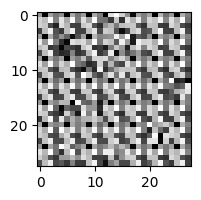

In [41]:
import random

# 测试定义的数据集
random.shuffle(dataset.data)

train_set,test_set = dataset.data[:700],dataset.data[700:]
print('数据集总长度为：',dataset.__len__())
print('训练集长度为：',len(train_set))
print('测试集长度为：',len(test_set))

img0,label0 = train_set[0]
print('图像和标签数据类型为',type(img0),type(label0))
print('图像和标签维度为',img0.shape,label0.shape)

print('第一条数据的标签为: ' + str(label0) +"   "+ new_labels_dict[int(label0)])

img0 = img0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(img0, cmap=plt.cm.binary)

In [42]:
# 读入数据时用到的批次大小
BATCHSIZE = 100

# 随机打乱训练数据的索引序号
random.shuffle(train_set)

# 定义数据生成器，返回批次数据
def data_generator():
    imgs_list = []
    labels_list = []
    for i in range(len(train_set)):
        img,label = train_set[i]
        # 将数据处理成希望的类型
        img = img.reshape(784,)
        img = img.astype('float32')
        label = label.astype('float32')

        imgs_list.append(img) 
        labels_list.append(label)
        if len(imgs_list) == BATCHSIZE:
            # 获得一个batchsize的数据，并返回
            yield np.array(imgs_list), np.array(labels_list)
            # 清空数据读取列表
            imgs_list = []
            labels_list = []

    # 如果剩余数据的数目小于BATCHSIZE，
    # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [43]:
# 声明数据读取函数，从训练集中读取数据
train_loader = data_generator
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        # 打印数据shape和类型
        print("打印第一个batch数据的维度,以及数据的类型:")
        print("图像维度: {}, 标签维度: {}, 图像数据类型: {}, 标签数据类型: {}".format(image_data.shape, label_data.shape, type(image_data), type(label_data)))
    break

打印第一个batch数据的维度,以及数据的类型:
图像维度: (100, 784), 标签维度: (100,), 图像数据类型: <class 'numpy.ndarray'>, 标签数据类型: <class 'numpy.ndarray'>


In [68]:
# 封装数据读取与处理函数
def load_data(mode = 'train'):

    # 随机打乱训练数据的索引序号
    random.shuffle(train_set)
    # 读入数据时用到的批次大小
    BATCHSIZE = 100

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    # 定义数据生成器，返回批次数据
    def data_generator():
        imgs_list = []
        labels_list = []
        if mode == 'eval':
            data_set = test_set
        else:
            data_set = train_set
        for i in range(len(data_set)):
            img, label = train_set[i]
            # 将数据处理成希望的类型
            img = img.reshape(784,)
            # 将数据处理成希望的类型
            # img = img.astype('float32')
            # label = label.astype('float32')

            # 在使用卷积神经网络结构时，uncomment 下面两行代码
            img = np.reshape(img, [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(label, [1]).astype('float32')

            # img = np.reshape(img, [1, IMG_ROWS, IMG_COLS]).astype('float32')
            # label = np.reshape(label, [1]).astype('int64')

            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [71]:
# 测试load_data
train_loader = load_data('train')
for batch_id, data in enumerate(train_loader()):
    print(batch_id,data,end='\t')
    break

0 (array([[[[-0.3882353 ,  0.39607844, -0.67058825, ..., -0.4509804 ,
           0.78039217,  0.70980394],
         [ 0.21568628, -0.88235295, -0.96862745, ..., -0.09019608,
          -0.5137255 , -0.85882354],
         [ 0.24705882,  1.        , -0.00392157, ...,  0.22352941,
          -0.11372549,  0.92156863],
         ...,
         [ 0.19215687,  0.42745098,  0.6784314 , ..., -0.14509805,
           0.5058824 ,  0.5921569 ],
         [-0.16078432, -0.35686275,  0.12941177, ..., -0.31764707,
          -0.35686275,  0.39607844],
         [ 0.60784316,  0.2       ,  0.7254902 , ..., -0.8039216 ,
          -0.6627451 ,  0.6392157 ]]],


       [[[-0.9607843 , -0.9843137 ,  1.        , ..., -0.42745098,
          -0.60784316, -0.8666667 ],
         [ 1.        ,  0.8666667 , -0.9607843 , ..., -0.85882354,
          -1.        , -0.49803922],
         [ 1.        , -0.9843137 , -1.        , ..., -0.9607843 ,
           0.67058825,  0.81960785],
         ...,
         [-0.8980392 , -1.   

In [72]:
# 多层卷积神经网络实现
class MyNet(paddle.nn.Layer):
     def __init__(self):
         super(MyNet, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)

    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
         else:
             return x

In [76]:
#网络结构部分之后的代码，保持不变
def train(model):
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    #四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())


    # 训练10轮
    EPOCH_NUM = 10
    iter = 0
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28
    loss_list = []
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练10批次的数据，打印下当前Loss的情况
            if batch_id % 10 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                # log_writer.add_scalar(tag = 'acc', step = iter, value = acc.numpy())
                # log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return loss_list

model = MyNet()
loss_list = train(model)

ValueError: (InvalidArgument) The type of data we are trying to retrieve (int64) does not match the type of data (float32) currently contained in the container.
  [Hint: Expected dtype() == phi::CppTypeToDataType<T>::Type(), but received dtype():10 != phi::CppTypeToDataType<T>::Type():9.] (at ..\paddle\phi\core\dense_tensor.cc:171)
  [operator < accuracy > error]